# Part 2: Selecting Engineered Features
In `feature_engineering.ipynb`, you learned how to engineer features from raw data and add them to your model. However, creating a feature does not mean it will always improve your model. We are now going to test and determine which features actually lead to measurable improvements in our models.

### Step 1: Test Your Baseline Model (No Engineered Features)

Start by creating a baseline model that will show how the model performs with **ONLY** raw features (i.e. before we add engineered features).

In [ ]:
pip install pandas numpy scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load the credit card data
df = pd.read_csv('data/UCI_Credit_Card.csv')

# Define baseline features (raw data only)
baseline_features = ['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'PAY_AMT1']

# Prepare the data
X_baseline = df[baseline_features].fillna(0)
y = df['default.payment.next.month']

# Split the data (IMPORTANT: use random_state=42 for consistent results)
X_train, X_test, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42
)

Now train the baseline model and check its performance:

In [7]:
# Train baseline model
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions
baseline_predictions = baseline_model.predict(X_test)

# Calculate metrics
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_precision = precision_score(y_test, baseline_predictions)
baseline_recall = recall_score(y_test, baseline_predictions)

print("BASELINE MODEL (Raw Features Only):")
print(f"Accuracy:  {baseline_accuracy:.4f} - Got {baseline_accuracy*100:.1f}% correct overall")
print(f"Precision: {baseline_precision:.4f} - When predicting default, right {baseline_precision*100:.1f}% of time")
print(f"Recall:    {baseline_recall:.4f} - Caught {baseline_recall*100:.1f}% of actual defaults")

BASELINE MODEL (Raw Features Only):
Accuracy:  0.7965 - Got 79.7% correct overall
Precision: 0.5569 - When predicting default, right 55.7% of time
Recall:    0.3427 - Caught 34.3% of actual defaults


### Step 2: Add Your Engineered Features
Now let's create some engineered features and see if any of them improve our model.

In [18]:
# Create engineered features using domain knowledge
df['utilization_rate'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1)
df['payment_rate'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1)
df['available_credit'] = df['LIMIT_BAL'] - df['BILL_AMT1']
df['is_graduate'] = (df['EDUCATION'] == 1).astype(int)
df['months_delayed'] = (df[['PAY_0', 'PAY_2', 'PAY_3']].values > 0).sum(axis=1)

# Replace infinity values with 0
df['utilization_rate'] = df['utilization_rate'].replace([np.inf, -np.inf], 0)
df['payment_rate'] = df['payment_rate'].replace([np.inf, -np.inf], 0)

### Step 3: Test Model WITH Engineered Features
We now need to test with the engineered features to see if they improve any of our metrics

In [19]:
# Combine baseline + engineered features
all_features = baseline_features + [
    'max_delinquency', 'payment_variance', 'ever_severely_late',
    'debt_increase_rate', 'payment_decrease_rate',
    'high_util_low_pay', 'total_months_late', 'avg_payment_ratio',
]

# Prepare the data
X_engineered = df[all_features].fillna(0)

# Split with SAME random_state for fair comparison!
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Train engineered model
engineered_model = RandomForestClassifier(n_estimators=100, random_state=42)
engineered_model.fit(X_train_eng, y_train_eng)

# Make predictions
engineered_predictions = engineered_model.predict(X_test_eng)

# Calculate metrics
eng_accuracy = accuracy_score(y_test_eng, engineered_predictions)
eng_precision = precision_score(y_test_eng, engineered_predictions)
eng_recall = recall_score(y_test_eng, engineered_predictions)

print("\nENGINEERED MODEL (With New Features):")
print(f"Accuracy:  {eng_accuracy:.4f} - Got {eng_accuracy*100:.1f}% correct overall")
print(f"Precision: {eng_precision:.4f} - When predicting default, right {eng_precision*100:.1f}% of time")
print(f"Recall:    {eng_recall:.4f} - Caught {eng_recall*100:.1f}% of actual defaults")


ENGINEERED MODEL (With New Features):
Accuracy:  0.8140 - Got 81.4% correct overall
Precision: 0.6271 - When predicting default, right 62.7% of time
Recall:    0.3701 - Caught 37.0% of actual defaults


### Step 4: Create Comparison Table
Now let's clearly see the improvement:

In [20]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Baseline', 'With Features'],
    'Accuracy': [baseline_accuracy, eng_accuracy],
    'Precision': [baseline_precision, eng_precision],
    'Recall': [baseline_recall, eng_recall]
})

print("\n" + "="*50)
print("MODEL COMPARISON:")
print(comparison.to_string(index=False))

# Calculate improvements
print("\nIMPROVEMENTS:")
print(f"Accuracy:  {(eng_accuracy - baseline_accuracy):.4f} ({(eng_accuracy - baseline_accuracy)*100:+.2f}%)")
print(f"Precision: {(eng_precision - baseline_precision):.4f} ({(eng_precision - baseline_precision)*100:+.2f}%)")
print(f"Recall:    {(eng_recall - baseline_recall):.4f} ({(eng_recall - baseline_recall)*100:+.2f}%)")


MODEL COMPARISON:
        Model  Accuracy  Precision   Recall
     Baseline    0.7965   0.556931 0.342727
With Features    0.8140   0.627097 0.370145

IMPROVEMENTS:
Accuracy:  0.0175 (+1.75%)
Precision: 0.0702 (+7.02%)
Recall:    0.0274 (+2.74%)


### Step 5: Identify Which Features Actually Helped
Use feature importance to see which engineered features mattered:

In [21]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': engineered_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTOP FEATURES BY IMPORTANCE:")
print(feature_importance.head(8).to_string(index=False))

# Which engineered features were valuable?
engineered_only = ['utilization_rate', 'payment_rate', 'available_credit', 
                   'is_graduate', 'months_delayed']
eng_importance = feature_importance[feature_importance['feature'].isin(engineered_only)]

print("\nYOUR ENGINEERED FEATURES RANKED:")
print(eng_importance.to_string(index=False))


TOP FEATURES BY IMPORTANCE:
              feature  importance
            BILL_AMT1    0.122649
    avg_payment_ratio    0.116241
                  AGE    0.114449
   debt_increase_rate    0.108048
            LIMIT_BAL    0.096985
                PAY_0    0.092532
             PAY_AMT1    0.092085
payment_decrease_rate    0.080885

YOUR ENGINEERED FEATURES RANKED:
Empty DataFrame
Columns: [feature, importance]
Index: []


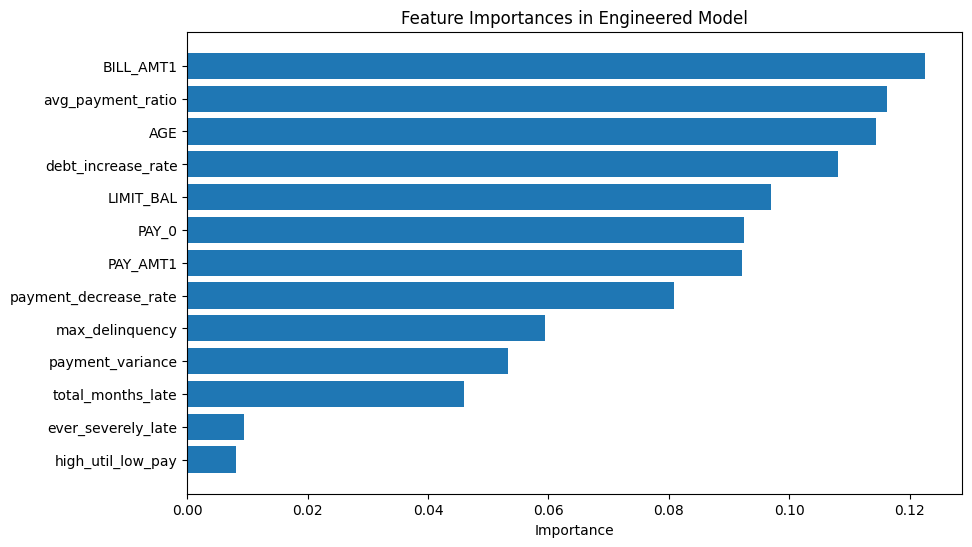

In [22]:
## Create a visualization of feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Engineered Model')
plt.gca().invert_yaxis()
plt.show()